In [1]:
# from astropy.io import ascii
# import os 
# import numpy as np
# dpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data'

# class_file_path =os.path.join(dpath,'class_info.dat')
# class_info = ascii.read(class_file_path)
# mask = np.isin(np.array(class_info['ztf_id']), ['ZTF18aahxdfs','ZTF19adcgabk','ZTF19aaruusi'])
# class_info[mask]

In [2]:
# mask = np.unique(class_info[class_info['MBH'] != 0]['MBH'],return_counts=True)[-1] != 1
# np.unique(class_info[class_info['MBH'] != 0]['MBH'])[mask]
# # np.unique(class_info[class_info['MBH'] != 0][['MBH']])[mask]
# # np.invert(np.isin(class_info[class_info['MBH'] != 0][['ztf_id']][np.unique(class_info[class_info['MBH'] != 0]['MBH'],return_index=True,)[-1]]

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
from sjoert.stellar import mag2flux, flux2mag
import pandas as pd
import forced_phot as fp #import flux_jy, chi2, gaussian, chi2_peak_finder
from astropy.io import ascii
from scipy.constants import c,h,k
import os
from scipy.stats import kstest,ks_2samp,ks_1samp,uniform
from astropy.cosmology import units as cu
from astropy import units as u
import astropy.constants as const

neowise = ascii.read(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\ZTF_neoWISE_flares_parent.dat')

param_label_dict = {'sigma_rise':r'$\sigma_{\text{rise}}$','tau_dec':r'$\tau_{\text{dec}}$',
                    'log10_sigma_rise':r'$\sigma_{\text{rise}}$','log10_tau_dec':r'$\tau_{\text{dec}}$',
                    'F_p':r'F$_{\text{peak}}$','peak_g':r'F$_{\text{p,g}}$','peak_r':r'F$_{\text{p,r}}$','MBH':r'$\log_{10}($M$_{\text{BH}}/M_{\odot})$',
                    'dmg':r'$\Delta$m$_g$','dmr':r'$\Delta$m$_r$','opt_df_over_rms':r'$\Delta$F$_{\text{g}}$/F$_{\text{rms}}$',
                    'df_over_rms':r'Dust echo strength ($\Delta$F$_{\text{IR}}/\text{F}_{\text{rms}}$)'}

inv_param_label_dict = dict((v, k) for k, v in param_label_dict.items())

#==
#Load in the data
dpath = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data'

#Class info
class_info = pd.read_csv(os.path.join(dpath,'transient_classinfo.txt'))
masked_class_info = class_info[class_info['fit_exists']]
#==
#get the df_over_rms data. These are yet another subset of the transients so we find them in the class_info frame
df_over_rms = neowise[['name','df_over_rms']]
#Get the catalogue of data
fullcatalogue = pd.read_csv(os.path.join(dpath,'transient_catalogue.txt'))

#Alter the selection by demanding Fir/Frms >= 3 (this can become 5 later maybe)
ztfmask_rms =  np.isin(df_over_rms['name'],fullcatalogue['ZTF_ID'].values)
print(fullcatalogue['in_selection'].sum())
df_extreme_mask = np.zeros(fullcatalogue.shape[0]).astype(bool)
df_extreme_mask_series = pd.DataFrame({'mask':df_extreme_mask},index = fullcatalogue['ZTF_ID'].values)
for ztf,df in df_over_rms:
    if df >= 3:
        df_extreme_mask_series.loc[ztf] = True

fullcatalogue['selection_old'] = fullcatalogue['in_selection'].values
fullcatalogue['in_selection'] *= df_extreme_mask_series['mask'].values
print(fullcatalogue['in_selection'].sum())

refmag_path = os.path.join(dpath,'refmags_good.txt')
refmag_df = pd.read_csv(refmag_path, sep=",")
refmag_df[refmag_df['ZTF_ID'] == 'ZTF19aaniqrr']

zeroref_g =  refmag_df['refmag_g'] == 0
zeroref_ztfs_g = refmag_df['ZTF_ID'][zeroref_g].values
bad_dmg = np.isin(fullcatalogue['ZTF_ID'].values,zeroref_ztfs_g)
fullcatalogue['bad_dmg'] = bad_dmg

zeroref_r = refmag_df['refmag_r'] == 0
zeroref_ztfs_r = refmag_df['ZTF_ID'][zeroref_r].values
bad_dmr = np.isin(fullcatalogue['ZTF_ID'].values,zeroref_ztfs_r)

fullcatalogue['bad_dmr'] = bad_dmr

masked_fullcatalogue = fullcatalogue[fullcatalogue['classified'].values]
catalogue = fullcatalogue[fullcatalogue['fit_quality_good'].values]


#Create a class info frame for black hole masses
id_mask = np.isin(masked_class_info['ztf_id'].values,df_over_rms['name'])
class_info_for_rms = masked_class_info[id_mask]
catalogue_for_rms = masked_fullcatalogue[id_mask]
#filter out zero MBHs
nonzero_mbh_for_rms = np.nonzero(class_info_for_rms['MBH'].values)
class_info_for_rms_masked = class_info_for_rms.iloc[nonzero_mbh_for_rms]
df_over_rms_masked = df_over_rms[nonzero_mbh_for_rms]




6151
812


In [78]:
class_info[class_info['ztf_id'].values == 'ZTF20abowque']

,ztf_id,RA,Dec,redshift,MBH,MBH_ref,classification,fit_exists
9478,ZTF20abowque,34.474809,-9.614141,0.0,8.267107,Hammerstein et al. 2,TDE,True


In [5]:
masked_fullcatalogue[(masked_class_info['classification'].values=='SN') * masked_fullcatalogue['in_selection'].values]

,Unnamed: 0,ZTF_ID,F_p,F_p_err,t_0,t_0_err,sigma_rise,sigma_rise_err,tau_dec,tau_dec_err,...,refmag_r,refmag_unc_r,classified,fit_quality_good,strong,in_selection,opt_df_over_rms,selection_old,bad_dmg,bad_dmr
691,691,ZTF18aaqkcso,7196.174728,16.975410,140.117483,0.030337,3.568056,0.014064,23.327311,0.043971,...,18.143,0.047,True,True,True,True,31.654270,True,False,False
1625,1625,ZTF18abhxidx,88.954163,2.004418,-165.077915,0.633435,4.957627,0.461180,29.997039,0.612132,...,19.967,0.051,True,True,True,True,109.467504,True,False,False
2633,2633,ZTF18acbwopo,191.669359,1.020253,-60.451450,0.332019,1.000000,0.808873,117.000480,0.536794,...,18.177,0.048,True,False,True,True,14.503426,True,False,False
5705,5705,ZTF19abcejoa,169.446725,3.177420,190.009937,0.331282,6.372626,0.298189,20.771499,0.496871,...,20.260,0.077,True,True,True,True,225.582884,True,False,False
6116,6116,ZTF19abkfxfb,154.247782,2.254634,222.288656,0.890742,51.497820,7.742317,41.743435,0.987964,...,19.425,0.061,True,True,True,True,64.009109,True,False,False
6873,6873,ZTF19acgonwy,248.142959,6.114264,299.466049,0.547502,6.864268,0.592261,28.137042,1.241165,...,17.118,0.052,True,True,True,True,16.014379,True,False,False
7094,7094,ZTF19acwrrvg,837.847245,4.468529,335.997834,0.080222,2.034551,0.167940,31.515490,0.193339,...,18.362,0.077,True,True,True,True,39.792538,True,False,False
7100,7100,ZTF19acxgwvo,378.623760,21.034994,336.147777,3.692382,2.873803,1.451885,59.328295,0.975244,...,17.965,0.077,True,False,True,True,12.514529,True,False,False
7958,7958,ZTF20aaqepvb,287.036222,5.259892,436.556107,0.614569,10.151776,0.576090,53.002293,0.885509,...,17.704,0.077,True,True,True,True,28.004526,True,False,False
8160,8160,ZTF20aavdcxo,85.542827,0.695889,484.000674,0.437693,12.033789,0.669051,52.862990,0.691294,...,18.269,0.110,True,True,True,True,13.245823,True,False,False


In [6]:
issorted = lambda x: np.all([x[i] < x[i+1] for i in range(x.shape[0]-1)])
issorted(class_info_for_rms['ztf_id'].values),issorted(np.array(df_over_rms['name']))

(True, True)

In [66]:

# neowise_alt = ascii.read(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\ZTF_neoWISE_flares_acflares.dat')
print(issorted(np.array(neowise['name'])))
# print(issorted(np.array(neowise_alt['name'])))

bad_TDEs =  ['ZTF20aamqmfk', 'ZTF20abfcszi', 'ZTF20achpcvt', 'ZTF20acitpfz', 'ZTF20acqoiyt', 'ZTF20acwytxn',
              'ZTF21aaaokyp', 'ZTF21aanxhjv', 'ZTF21abaxaqq', 'ZTF21abqhkjd', 'ZTF21acafvhf']

# for tde in bad_TDEs:
    # print(neowise_alt[neowise_alt['name'] == tde]['redshift'])

# print(neowise_alt[np.isin(neowise_alt['name'],bad_TDEs)][['name','redshift']])
# print(neowise[np.isin(neowise['name'],bad_TDEs)][['name','redshift']])


# redshift_df = class_info_for_rms[['ztf_id','redshift','MBH']].iloc[np.nonzero(class_info_for_rms['MBH'].values)]
redshift_mask = (neowise['redshift'] != 0) #* np.isin(class_info_for_rms['ztf_id'].values,np.array(neowise['name'])) #* (class_info_for_rms['MBH'].values != 0)
redshift_df = class_info_for_rms.copy()
redshift_df['redshift'] = np.array(neowise['redshift'])
redshift_df['df_over_rms'] = np.array(neowise['df_over_rms'])
redshift_df = redshift_df[redshift_mask]

# print(redshift_df[np.isin(redshift_df['ztf_id'].values,bad_TDEs)])

IR_flux = np.array(neowise['post_max_flux_w1'][redshift_mask])  #flux diff in Jy and mag2flux() gives Jy

neg_flux_mask = np.array(IR_flux) > 0
IR_flux = IR_flux[neg_flux_mask]
redshift_df = redshift_df[neg_flux_mask]
redshift_df['IR_flux'] = IR_flux

class_info_for_rms_masked[['ztf_id','redshift','MBH','classification']][class_info_for_rms_masked['redshift'].values == 0]
class_info_for_rms_masked[['ztf_id']][class_info_for_rms_masked['redshift'].values == 0].to_numpy().flatten()

redshift_df[redshift_df['classification'].values == 'AGN']['redshift'].max()

True


0.35

In [67]:

def lum_from_z(flux,z):
    redshift = z * cu.redshift
    distances = redshift.to(u.m,equivalencies = cu.redshift_distance())
    flux = flux * u.Jy #flux in jansky
    flux *=  (3.35 * u.um).to(u.Hz,equivalencies=u.spectral()) #flux at 3.35 um which is effective wavelength of W1
    print(flux.unit)
    flux_si = flux.to((u.erg * (u.s)**(-1)) * u.m**(-2) )
    lum = flux_si * 4*np.pi * np.square(distances)
    print(lum.unit)
    # lum = lum.to(u.erg*(u.s**(-1)))
    return lum.value


# lums = lum_from_z(np.abs(IR_flux),redshift_df['redshift'].values)
lums = lum_from_z(IR_flux,redshift_df['redshift'].values)
redshift_df['lum_IR'] = lums
# print(redshift_df[redshift_df['classification'].values != 'Unknown'].to_markdown())

Hz Jy
erg / s


elem = 'AGN', 1416
elem = 'SN', 113
elem = 'TDE', 46
elem = 'Unknown', 730
Total: 2305


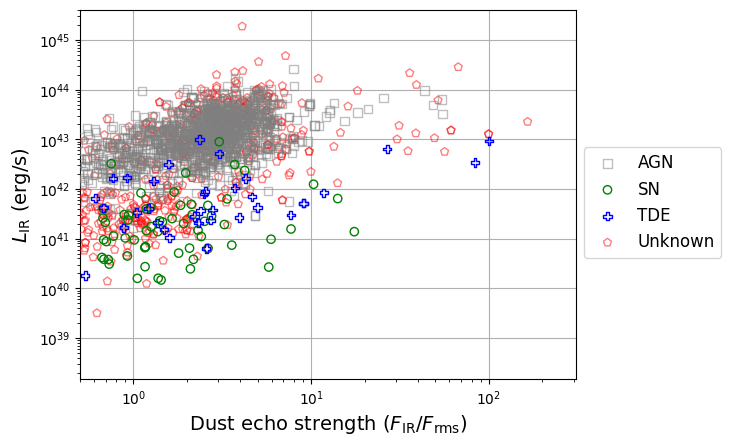

In [68]:
dust_echoes_for_lum = np.array(redshift_df['df_over_rms'])

colordict = {"AGN":'gray',"SN":"green","TDE":'blue','Unknown':'red'}
markerdict = {"AGN":'s',"SN":"o","TDE":'P','Unknown':'p'}
zorder_dict = {"SN":9,"TDE":10,'AGN':7,'Unknown':6}
alpha_dict = {"SN":1,"TDE":1,'AGN':0.5,'Unknown':0.5}


fig,ax = plt.subplots()
for elem in np.unique(redshift_df['classification']):
    elemmask = redshift_df['classification'].values == elem
    print(f'{elem = }, {sum(elemmask)}')
    # if elem == 'SN': z = 5
    # else: z = 1
    plt.scatter(dust_echoes_for_lum[elemmask],redshift_df['lum_IR'].values[elemmask],label=elem,zorder=zorder_dict[elem],edgecolors=colordict[elem],marker=markerdict[elem],facecolors='none',alpha=alpha_dict[elem])

print(f'Total: {redshift_df.shape[0]}')

plt.legend(bbox_to_anchor=(1,0.65),fontsize=12)
plt.xlabel(r'Dust echo strength ($F_{\mathrm{IR}}/F_{\mathrm{rms}}$)',fontsize=14)
plt.ylabel(r'$L_{\mathrm{IR}}$ (erg/s)',fontsize=14)
plt.yscale('symlog')
plt.xscale('log')
plt.xlim(left=0.5)
plt.grid()
from matplotlib import ticker as mticker
ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','df_over_rms_vs_lumir.png'),dpi=400)
plt.show()

In [10]:
neowise[(neowise['redshift'] == 0) * (neowise['MBH'] != 0)]


name,t_0,t_0_err,F_0g,F_0g_err,F_0r,F_0r_err,log10_F_p,log10_F_p_err,log10_sigma_rise,log10_sigma_rise_err,log10_tau_dec,log10_tau_dec_err,log10_T,log10_T_err,ra,dec,N_pre,N_post,echo_duration_w1,echo_duration_w2,pre_median_flux_w1,pre_median_flux_w2,pre_median_e_flux_w1,pre_median_e_flux_w2,pre_median_total_flux_w1,pre_median_total_flux_w2,pre_rms_flux_w1,pre_rms_flux_w2,post_max_flux_w1,post_max_flux_w2,e_post_max_flux_w1,e_post_max_flux_w2,post_mean_flux_w1,post_mean_flux_w2,post1yr_max_flux_w1,post1yr_max_flux_w2,post1yr_mean_flux_w1,post1yr_mean_flux_w2,df_over_rms,redshift,MBH,MBH_ref,classification,flare_peak_jd,flare_postpeak_duration_day,qclass
str12,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,str19,str4,float64,float64,str4


In [11]:
# masked_fullcatalogue = fullcatalogue[fullcatalogue['classified'].values]

# print(masked_class_info[(masked_class_info['ztf_id'] == 'ZTF19aaniqrr')])

test = masked_fullcatalogue[masked_fullcatalogue['classified']]
test = masked_fullcatalogue[(masked_class_info['classification'] == 'TDE').values]
test[['ZTF_ID','tau_dec','tau_dec_err']][test['tau_dec'].values > 500]

,ZTF_ID,tau_dec,tau_dec_err
7652,ZTF20aahmtso,506.436453,4.867292


In [12]:
classmask =  (masked_class_info['classification'].values == 'TDE') * (masked_class_info['MBH'].values != 0) * (masked_class_info['ztf_id'].values != 'ZTF18acaqdaa')
mbh = masked_class_info['MBH'].values[classmask]
tau = masked_fullcatalogue['log10_tau_dec'].values[classmask]
from scipy.stats import pearsonr,kendalltau
# print(masked_fullcatalogue[['ZTF_ID','fit_quality_good']][TDEmask])
print(mbh.shape)
pearsonr(mbh,tau),kendalltau(mbh,tau)

(26,)


(PearsonRResult(statistic=0.48239361927609525, pvalue=0.012567080037394724),
 SignificanceResult(statistic=0.32049344670791013, pvalue=0.02185501129713877))

In [13]:
params = ['log10_sigma_rise','log10_tau_dec','dmg','dmr','MBH','df_over_rms','opt_df_over_rms']

def construct_sample(x,y,classification: str = 'TDE'):
    if (x not in params) or (y not in params):
        raise ValueError("One of the parameters not valid.")
    
    if ([x,y] == ['df_over_rms','MBH']) or ([x,y] == ['MBH','df_over_rms']):
        class_info_to_use = class_info_for_rms_masked.copy() #nonzero mbhs already filtered out
        catalogue_to_use = masked_fullcatalogue[np.isin(masked_fullcatalogue['ZTF_ID'].values,class_info_to_use['ztf_id'].values)]
        if classification == 'AGN':
            extrememask = catalogue_to_use['in_selection'].values
        else:
            extrememask = True

        classmask = (class_info_to_use['classification'].values == classification) * extrememask
        param1 = class_info_to_use['MBH'].values[classmask]
        param2 = np.array(df_over_rms_masked['df_over_rms'])[classmask]
        N = sum(classmask)

    elif 'df_over_rms' in [x,y]:
        class_info_to_use = class_info_for_rms.copy() #nonzero mbhs not filtered out
        catalogue_to_use = masked_fullcatalogue[np.isin(masked_fullcatalogue['ZTF_ID'].values,class_info_to_use['ztf_id'].values)]

        if classification == 'AGN':
            extrememask = catalogue_to_use['in_selection'].values
        else:
            extrememask = True
        classmask = (class_info_to_use['classification'].values == classification)* extrememask

        good_fit_mask = catalogue_to_use['fit_quality_good'].values * classmask

        catalogue_param = np.array([x,y])
        catalogue_param = catalogue_param[catalogue_param != 'df_over_rms'][0]

        param1 = np.array(df_over_rms['df_over_rms'])[good_fit_mask]
        param2 = catalogue_to_use[catalogue_param].values[good_fit_mask]
        N = sum(good_fit_mask)
        
    elif 'MBH' in [x,y]: 
        #so now MBH and a catalogue parameter
        class_info_to_use = masked_class_info.copy()
        catalogue_to_use = masked_fullcatalogue.copy()

        if classification == 'AGN':
            extrememask = catalogue_to_use['in_selection'].values
        else:
            extrememask = True
        classmask = (class_info_to_use['classification'].values == classification) * extrememask

        mask = (catalogue_to_use['fit_quality_good'].values) * (class_info_to_use['MBH'].values != 0) * classmask

        if 'log10_tau_dec' in [x,y] and classification == 'TDE':
            idx = np.where(catalogue_to_use['ZTF_ID'].values == 'ZTF20abowque')[0]
            mask[idx] = True

        catalogue_param = np.array([x,y])
        catalogue_param = catalogue_param[catalogue_param != 'MBH'][0]

        param1 = class_info_to_use['MBH'].values[mask]
        param2 = catalogue_to_use[catalogue_param].values[mask]
        N = np.sum(mask)

    else:
        catalogue_to_use = masked_fullcatalogue.copy()
        class_info_to_use = masked_class_info.copy()

        if classification == 'AGN':
            extrememask = catalogue_to_use['in_selection'].values
        else:
            extrememask = True

        classmask = (class_info_to_use['classification'].values == classification) * extrememask
        good_fit_mask = masked_fullcatalogue['fit_quality_good'].values
        
        param1 = catalogue_to_use[x].values[classmask * good_fit_mask]
        param2 = catalogue_to_use[y].values[classmask * good_fit_mask]
        N = np.sum(good_fit_mask * classmask)

    return param1,param2,N


def construct_kendalltau_table(params=params,classification='TDE',value='pvalue'):
    tableframe = pd.DataFrame(np.zeros((len(params),len(params)-1)),columns=params[:-1],index=params)
    for x in params: #exclude opt_df_over_rms from columns
        for y in params[:-1]:
            if x == y:
                tableframe.loc[x,y] = '-'
            else:
                param1,param2,N = construct_sample(x,y,classification=classification)
                if value.lower() == 'pvalue':
                    stat = kendalltau(param1,param2).pvalue
                elif value.lower() == 'tau' or value.lower() == 'statistic':
                    stat = kendalltau(param1,param2).statistic
                # print(f'{x=},{y=}')
                tableframe.loc[x,y] = f'{stat:.2e} ({N})'

    # param1,param2 = construct_sample(params[0],params[1])

    return tableframe

# kendalltau_table = construct_kendalltau_table()
# kendalltau_table_TDE = construct_kendalltau_table(classification='TDE')
# kendalltau_table_TDE_tau = construct_kendalltau_table(classification='TDE',value='tau')
# kendalltau_table_AGN = construct_kendalltau_table(classification='AGN')
# kendalltau_table_AGN_tau = construct_kendalltau_table(classification='AGN',value='tau')

# print(kendalltau_table_TDE.to_latex())
# print()
# print(kendalltau_table_TDE_tau.to_latex())
print()
# print(kendalltau_table_AGN.to_latex())
print()
# print(kendalltau_table_AGN_tau.to_latex())
        

In [14]:
# # print(kendalltau_table_TDE.to_latex())
# # print()
# print(kendalltau_table_TDE_tau.to_latex())
# print()
# print(kendalltau_table_AGN.to_latex())
# print()
# print(kendalltau_table_AGN_tau.to_latex())

In [15]:
test = np.array(df_over_rms_masked[class_info_for_rms_masked['classification'].values == 'TDE'])['df_over_rms']
test[np.array(test) != 0]
sum(df_over_rms['df_over_rms'] == 0)

63

In [16]:
print(fullcatalogue.shape)
print(masked_fullcatalogue.shape)
print(class_info['fit_exists'].sum())

(13467, 42)
(13456, 42)
13456


In [17]:
masked_fullcatalogue['fit_quality_good'].sum()  

9577

In [18]:
(df_over_rms[class_info_for_rms['classification'].values == 'AGN']['df_over_rms'] >= 3).sum()

507

In [19]:
extrememask = masked_fullcatalogue['selection_old'].values * masked_fullcatalogue['fit_quality_good'].values
print(f'Total extremes: {sum(extrememask)}')
for elem in np.unique(masked_class_info['classification'].values):
    elemmask = masked_class_info['classification'].values == elem
    extreme_elemmask = extrememask[elemmask]
    print(f"{elem} \n{100*'='}")
    print(f'Total: {elemmask.sum()}')
    print(f"Good fit: {masked_fullcatalogue['fit_quality_good'][elemmask].sum()}")
    print(f"Extreme: {extreme_elemmask.sum()}")
    echo_elem_mask = (class_info_for_rms['classification'].values == elem)
    bhmask = (masked_class_info[elemmask]['MBH'] != 0)
    print(f'MBH: {bhmask.sum()}')
    print(f'Dust echo: {np.array(df_over_rms[echo_elem_mask]).shape[0]}')
    print()

# print(df_over_rms)
    # if elem == 'TDE':
    #     tdedata = masked_fullcatalogue[elemmask]
    #     # print(tdedata[np.invert(tdedata['in_selection'])][['ZTF_ID','log10_tau_dec','in_selection','fit_quality_good']])
    #     print(tdedata[tdedata['dmg'] > 1][['ZTF_ID','dmg','dmr','in_selection']])
    #     print(tdedata[np.invert(tdedata['in_selection'].values)][['ZTF_ID','log10_sigma_rise','tau_dec','dmg','dmr']])

Total extremes: 4543
AGN 
Total: 1831
Good fit: 1391
Extreme: 255
MBH: 1829
Dust echo: 1558

SN 
Total: 169
Good fit: 132
Extreme: 123
MBH: 46
Dust echo: 140

TDE 
Total: 55
Good fit: 52
Extreme: 51
MBH: 27
Dust echo: 48

Unknown 
Total: 11401
Good fit: 8002
Extreme: 4114
MBH: 960
Dust echo: 7857



In [20]:
(masked_class_info['classification'] != 'Unknown').sum()

2055

In [21]:
simeon_data = pd.read_csv(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\dump\all_nuclear_transients.csv')

In [22]:
unknownmask = (masked_class_info['classification'] == 'Unknown').values
unknown_with_mbh = masked_class_info[['ztf_id','MBH']][unknownmask].iloc[np.nonzero(masked_class_info['MBH'][unknownmask].values)]
# print(unknown_with_mbh.to_markdown())
#get the catalogue values and add the blackhole mass to them
unknown_with_mbh_catalogue = fullcatalogue[np.isin(fullcatalogue['ZTF_ID'].values,unknown_with_mbh['ztf_id'].values)].copy()
unknown_with_mbh_catalogue['MBH'] = unknown_with_mbh['MBH'].values

#get the extreme flares
unknown_with_mbh_extreme = unknown_with_mbh_catalogue[unknown_with_mbh_catalogue['fit_quality_good'].values * unknown_with_mbh_catalogue['selection_old'].values]
#get the df_over_rms values that exist and add to the dataframe
extreme_unknown_rms_mask = np.isin(unknown_with_mbh_extreme['ZTF_ID'].values, np.array(df_over_rms_masked['name']))
unknown_with_mbh_extreme =  unknown_with_mbh_extreme[extreme_unknown_rms_mask]
extreme_rms = df_over_rms_masked[np.isin(np.array(df_over_rms_masked['name']),unknown_with_mbh_extreme['ZTF_ID'].values)]
unknown_with_mbh_extreme['df_over_rms'] = np.array(extreme_rms['df_over_rms'])

#sort by dust echo strength
unknown_with_mbh_extreme.sort_values(by='df_over_rms',ascending=False,inplace=True)
unknown_with_mbh_extreme.reset_index(drop=True,inplace=True)

radecs = simeon_data[np.isin(simeon_data['ztf_id'].values, unknown_with_mbh_extreme['ZTF_ID'].values)][['RA','Dec']]
unknown_with_mbh_extreme['RA'] = radecs['RA'].values
unknown_with_mbh_extreme['Dec'] = radecs['Dec'].values


def sig_figs(x: float, precision: int):
    """
    Rounds a number to number of significant figures
    Parameters:
    - x - the number to be rounded
    - precision (integer) - the number of significant figures
    Returns:
    - float
    """
    x = np.array(x,dtype=float)
    precision = int(precision)

    return np.array([np.round(x[i], -int(np.floor(np.log10(abs(x[i])))) + (precision - 1)) for i in range(x.shape[0])])


unknown_with_mbh_extreme_rounded = unknown_with_mbh_extreme.copy()
for elem in ['MBH','df_over_rms','opt_df_over_rms']:
    unknown_with_mbh_extreme_rounded[elem] = sig_figs(unknown_with_mbh_extreme[elem],precision=4)

# print(sig_figs(unknown_with_mbh_extreme[:50]['df_over_rms'].values,precision=4))

print(unknown_with_mbh_extreme_rounded[:50][['ZTF_ID','MBH','df_over_rms','opt_df_over_rms']].to_latex(index=False,longtable=True))

\begin{longtable}{lrrr}
\toprule
      ZTF\_ID &   MBH &  df\_over\_rms &  opt\_df\_over\_rms \\
\midrule
\endfirsthead

\toprule
      ZTF\_ID &   MBH &  df\_over\_rms &  opt\_df\_over\_rms \\
\midrule
\endhead
\midrule
\multicolumn{4}{r}{{Continued on next page}} \\
\midrule
\endfoot

\bottomrule
\endlastfoot
ZTF19abclykm & 7.060 &       51.860 &           10.410 \\
ZTF19aatubsj & 7.100 &       39.180 &           33.580 \\
ZTF20aabcemq & 6.373 &       38.880 &           18.590 \\
ZTF18abjjkeo & 6.400 &       30.500 &           12.840 \\
ZTF19abvgxrq & 6.400 &       13.450 &           17.930 \\
ZTF20aaaweke & 7.406 &        9.982 &           10.750 \\
ZTF20abbbyhe & 6.506 &        9.055 &           20.740 \\
ZTF19abkdlkl & 6.487 &        8.895 &           63.490 \\
ZTF18aasvknh & 6.647 &        7.618 &           13.870 \\
ZTF18aahybgv & 6.551 &        6.905 &           85.990 \\
ZTF21abmjobi & 7.521 &        6.857 &           14.100 \\
ZTF20aagyaug & 8.316 &        6.802 &           1

C:\Users\timvd\AppData\Local\Temp\ipykernel_19652\3754003163.py:46: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(unknown_with_mbh_extreme_rounded[:50][['ZTF_ID','MBH','df_over_rms','opt_df_over_rms']].to_latex(index=False,longtable=True))


In [23]:
# ztf = 'ZTF20abudrin'
# allztfs = []
# clean_counter = 0
# param_counter = 0
# for folder in os.listdir(dpath):
#     if folder.isnumeric():
        
#         yearfolder = os.path.join(dpath,folder)
#         # allztfs += os.listdir(yearfolder)[1:]
#         for t in os.listdir(yearfolder)[1:]:
#             # print(t)
#             # if t == ztf:
#                 # print('It is in here!')
#                 # print(os.listdir(os.path.join(yearfolder,t)))
#             cleanflag = True
#             paramflag =  True
#             for file in os.listdir(os.path.join(yearfolder,t)):
#                 if 'clean' in file and cleanflag:
#                     # print(file)
#                     clean_counter += 1
#                     cleanflag = False
#                 if 'parameters' in file and paramflag:
#                     param_counter += 1
#                     paramflag = False

# print(clean_counter)
# print(param_counter)
# # print(len(allztfs))
# # simeon = pd.read_csv(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Data\dump\all_nuclear_transients.csv')
# # print(simeon.shape)
# # print(np.sum(np.isnan(simeon['RA'])))
# # simeon.dropna().shape

In [24]:
def mbh_cumul_hist(density=True,save = False,catal=class_info) -> None:
    """Creates either a CDF or cumaltive sum distribution of black hole masses from transients, differentiating between 
       strong AGN (defined as delta m < 1 in at least one of the green and red filter).  
    

    Args:
        density (bool, optional): if True plots a CDF else a cumulative sum. Defaults to True.
        save (bool, optional): for saving the figure. Defaults to False.
        catal (pandas.DataFrame, optional): Dataframe holding the catalogue information, e.g. the classification and black hole mass. Defaults to class_info.
    """
    mbh_indx = np.nonzero(catal['MBH'].values)
    cat = catal.copy() #keep the original
    # cat = cat.iloc[mbh_indx] #filter out only the ones with known mbh data
    
    cat_masked = cat[cat['fit_exists'].values] #we need fit results to see if a burst is "strong"
    #create the mask to filter out the strong AGNs, so it needs to be an AGN, be a strong burst and have a non-zero Mbh (0 MBH means it is unknown)
    strongmask = (cat_masked['classification'].values == 'AGN') * (fullcatalogue[fullcatalogue['classified']]['strong'].values) * (cat_masked['MBH'] != 0)

    mbh_strong = cat_masked['MBH'][strongmask].values
    cat = cat.iloc[mbh_indx]
    agnmask = (cat['classification'].values == 'AGN') 
    mbh_other = cat['MBH'][agnmask].values

    print(ks_2samp(mbh_strong,mbh_other))

    n_bins = np.histogram_bin_edges(cat['MBH'].values,bins=30)

    fig,ax = plt.subplots()
    n, bins, patches = ax.hist(mbh_strong, n_bins, density=density, histtype='step',
                           cumulative=True, label='Extreme AGN flare')
    ax.hist(mbh_other, n_bins, density=density, histtype='step',
                           cumulative=True, label='Normal AGN flare')

    ax.set_xlabel(r'$\log_{10}\left(\text{M}_{\text{BH}}/M_{\odot}\right)$')
    print('HERE',ax.get_ylim())
    if density: ylabel = "CDF"
    else: ylabel = 'Cumulative sum'
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()
    plt.show()

KstestResult(statistic=0.13566238882710835, pvalue=1.422982412981963e-09, statistic_location=8.10328556465, statistic_sign=-1)
HERE (0.0, 1.05)


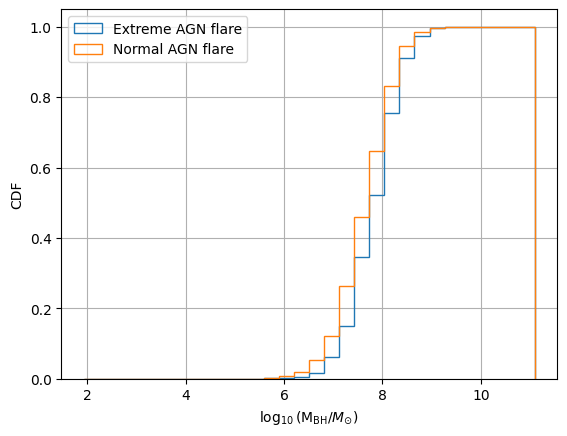

In [25]:
mbh_cumul_hist()
# mbh_cumul_hist(density=False)

In [150]:
class_info_with_fit = class_info[class_info['fit_exists']] #class info for which there is known fit dta
catalogue_masked_full = fullcatalogue[fullcatalogue['classified']] #parameters for which there is an instance in the class_info data


plotfolder = r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots\marginal_plots'

mapping = {'ZTF19aabbnzo':'18lna','ZTF18abjjkeo':'20hle','ZTF20aamqmfk':"20ddv",'ZTF19aapreis':'19dsg',
           'ZTF19aatubsj':'19fdr','ZTF19aaejtoy':'19aalc',
           'ZTF18acpdvos':'18hyz','ZTF19abzrhgq':'19qiz','ZTF22aacgcwv':'22dyt', 'ZTF19abclykm':'19meh'}

mappingKeys = list(mapping.keys())
mappingKeys.sort()
mapping = {i: mapping[i] for i in mappingKeys}

def scatter_histogram_plot(x,y,logy=False,logx=False,save=True,filtlist=[],xlabel=None,ylabel=None,
                           mark_certain_flares=False,different_class_info = None,savename=None,fsize=14,lims=(None,None)):
    #x,y are names of the columns holding the data to be plotted

    #uncomment to always filter out SNe if we plot MBH on the x-axis
    # if x  == 'MBH':
    #     if 'SN' not in filtlist:
    #         filtlist += ['SN']
    if different_class_info is None:
        class_info_masked = class_info_with_fit.copy()
        catalogue_masked = catalogue_masked_full.copy()

        good_fit_mask = catalogue_masked['fit_quality_good'].values 
        if 'MBH' in [x,y]: #we need a BH mass estimate
            # print('MBH filter activated')
            good_fit_mask *= (class_info_masked['MBH'].values != 0)
        
        if 'dmg' in [x,y]:
            # print('dmg filter activated')
            good_fit_mask *= np.invert(catalogue_masked['bad_dmg'].values) #get bad reference mag instances out

        if 'dmr' in [x,y]:
            # print('dmr filter activated')
            good_fit_mask *= np.invert(catalogue_masked['bad_dmr'].values) #get bad reference mag instances out

        class_info_masked = class_info_masked[good_fit_mask]

        catalogue_masked = catalogue_masked[good_fit_mask]

    else:
        class_info_masked = different_class_info.copy()
        catalogue_masked = catalogue_masked_full.copy()
        catalogue_masked = catalogue_masked[np.isin(catalogue_masked['ZTF_ID'].values,class_info_masked['ztf_id'])]

    class_info_masked = class_info_masked.sort_values(by='ztf_id')
    catalogue_masked = catalogue_masked.sort_values(by='ZTF_ID')
    #get the data from the masked dataframes. It must be the masked ones since we need to combine the two
    #you can also input straight arrays for ease. If you do so, input xlabel and ylabel as string for labeling axes manually
    if type(x) is str:
        try:
            xdata = catalogue_masked[x].values
        except (KeyError,TypeError):
            xdata = class_info_masked[x].values
    else:
        xdata = x
        x = xlabel
    if type(y) is str:
        try:
            ydata = catalogue_masked[y].values
        except (KeyError,TypeError):
            ydata = class_info_masked[y].values
    else:
        ydata = y
        y = ylabel

    colordict = {"AGN":'gray',"SN":"green","TDE":'blue','Unknown':'red'}
    markerdict = {"AGN":'s',"SN":"o","TDE":'P','Unknown':'p'}

    fig = plt.figure(layout='constrained')
    #main axis for the scatterplot
    ax = fig.add_gridspec(top=0.75, right=0.75).subplots()
    if logy: set_yscale = 'symlog'
    else: set_yscale = 'linear'
    if logx: set_xscale = 'symlog'
    else: set_xscale = 'linear'

    if 'Dust echo' in y:
        ylimmulti = 1.5
    else:
        ylimmulti = 1.1

    if x in ['MBH',param_label_dict['MBH']]:
        if lims == (None,None):
            xlim = (4,10) #have MBH forced between 4 and 10
            ylim = (min(ydata)-0.1,ylimmulti*max(ydata))
        else:
            xlim,ylim = lims
            # xlim = (ylimmulti*xlim[0],ylimmulti*xlim[1])
            # ylim = (ylimmulti*ylim[0],ylimmulti*ylim[1])
        ax.set(xlim=xlim,ylim=ylim,yscale=set_yscale,xscale=set_xscale)

    elif x in ['df_over_rms',param_label_dict['df_over_rms']]:
        if lims == (None,None):
            xlim = (0,1.25*max(xdata))
            # xlim = ax.get_xlim()
            if y in ['MBH',param_label_dict['MBH']]:
                ylim = (4,10)
            else:
                ylim = (min(ydata)-0.1,ylimmulti*max(ydata))
            # ylim = ax.get_ylim()
        else:
            xlim,ylim = lims
            # xlim = (ylimmulti*xlim[0],ylimmulti*xlim[1])
            # ylim = (ylimmulti*ylim[0],ylimmulti*ylim[1])
        ax.set(xlim=xlim,ylim=ylim,yscale=set_yscale,xscale=set_xscale)

    else:
        if lims == (None,None):
            xlim=(min(xdata)-0.1,1.05*max(xdata))
            if y in ['MBH',param_label_dict['MBH']]:
                ylim = (4,10)
            else:
                ylim=(min(ydata)-0.1,ylimmulti*max(ydata))
        else:
            xlim,ylim = lims
            # ylim *= ylimmulti
        ax.set(xlim=xlim,ylim=ylim,yscale=set_yscale,xscale=set_xscale)

    try:
        ax.set_xlabel(xlabel=param_label_dict[x],fontsize=fsize)
        ax.set_ylabel(ylabel=param_label_dict[y],fontsize=fsize)
    except:
        ax.set_xlabel(xlabel,fontsize=fsize)
        ax.set_ylabel(ylabel,fontsize=fsize)
    
    #draw in the box if applicable
    sigma_cutoff = 2 # was np.log10(150)
    cutoff_dict = {'log10_sigma_rise':2,'log10_tau_dec':np.log10(500),'dmg':1,'dmr':1,'df_over_rms':3}
    keys = list(cutoff_dict.keys())
    if (type(x) is str and type(y) is str):

        if y in ['df_over_rms',param_label_dict['df_over_rms']]:
            upper_lim = True
        else:
            upper_lim = False

        draw_vline = True
        draw_hline = True
        try:
            cutoff_value_x = cutoff_dict[x]
        except KeyError:
            try:
                cutoff_value_x = cutoff_dict[inv_param_label_dict[x]]
            except KeyError:
                cutoff_value_x = np.max(xdata)
                draw_vline = False
        
        try:
            cutoff_value_y = cutoff_dict[y]
        except KeyError:
            try:
                cutoff_value_y = cutoff_dict[inv_param_label_dict[y]]
            except KeyError:
                cutoff_value_y = np.max(ydata)
                draw_hline = False
        
        if draw_vline:
            if upper_lim:
                ax.vlines(cutoff_value_x,cutoff_value_y,np.max(ydata),colors='black',linestyles='dashed',zorder=15,alpha=0.75)
            else:
                ax.vlines(cutoff_value_x,np.min(ydata),cutoff_value_y,colors='black',linestyles='dashed',zorder=15,alpha=0.75)

        if draw_hline:
            if x in ['df_over_rms',param_label_dict['df_over_rms']]:
                ax.hlines(cutoff_value_y,cutoff_value_x,np.max(xdata),colors='black',linestyles='dashed',zorder=15,alpha=0.75)
            else:
                ax.hlines(cutoff_value_y,np.min(xdata),cutoff_value_x,colors='black',linestyles='dashed',zorder=15,alpha=0.75)

    #create the marginal axes
    ax_histx = ax.inset_axes([0, 1.075, 1, 0.5], sharex=ax)
    ax_histy = ax.inset_axes([1.075, 0, 0.5, 1], sharey=ax)
    # no labels
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    ax_histx.set(ylabel='CDF')
    ax_histy.set(xlabel='Density')

    classifications = class_info_masked['classification'].values
    if mark_certain_flares:
        interesting_flares = np.array(list(mapping.keys()))
        flaremask = np.isin(class_info_masked['ztf_id'].values,interesting_flares)
        interesting_flares = interesting_flares[np.isin(interesting_flares,class_info_masked['ztf_id'].values)]
        interesting_classifications = class_info_masked[flaremask]['classification'].values
        flare_x, flare_y = xdata[flaremask], ydata[flaremask]


    # the scatter plot:
    zorder_dict = {"SN":9,"TDE":10,'AGN':7,'Unknown':6}
    alpha_dict = {"SN":1,"TDE":1,'AGN':0.5,'Unknown':0.25}

    for elem in np.unique(classifications):
        classmask = (classifications == elem)

        if elem in filtlist:
            continue #do not plot the classes you don't want to see
        else:
            ax.scatter(xdata[classmask],ydata[classmask],edgecolors=colordict[elem],marker=markerdict[elem],s=15,zorder=zorder_dict[elem],label=elem,facecolors='none',alpha=alpha_dict[elem])
                        
        ax_histy.hist(ydata[classmask], bins='auto', orientation='horizontal',histtype='step',density=True,color=colordict[elem])
        ax_histx.hist(xdata[classmask], bins='auto',histtype='step',density=True,color=colordict[elem],cumulative=True)
    
    if mark_certain_flares:
        if lims != (None,None):
            extra_mult = 0.015
            limflag = True
        else:
            extra_mult = 0
            limflag = False
        for i,n in enumerate(interesting_flares):
            elem = interesting_classifications[i] #the classification
            textcolordict = colordict.copy()
            textcolordict['AGN'] = 'black'
            text = mapping[n]
            if text == '19qiz':
                txt = ax.text(flare_x[i]*(0.9+4*extra_mult),flare_y[i]/(0.88+extra_mult),text,zorder=100,fontsize=fsize-6,fontweight=500,color=textcolordict[elem])
                txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])
                
            elif text == '20iq':
                txt = ax.text(flare_x[i]-10,flare_y[i]/(0.88+extra_mult),text,zorder=100,fontsize=fsize-6,fontweight=500,color=textcolordict[elem])
                txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])
                
            else:
                if limflag:
                    if (xlim[0] < flare_x[i] < xlim[1]) and  (ylim[0] < flare_y[i] < ylim[1]):
                        txt = ax.text(flare_x[i]*(1.025-extra_mult),flare_y[i]*(0.88+2*extra_mult),text,zorder=100,fontsize=fsize-6,fontweight=500,color=textcolordict[elem])
                        txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])
                else:
                    txt = ax.text(flare_x[i]*(1.025-extra_mult),flare_y[i]*(0.88+extra_mult),text,zorder=100,fontsize=fsize-6,fontweight=500,color=textcolordict[elem])
                    txt.set_path_effects([PathEffects.withStroke(linewidth=0.5, foreground='black')])
            # ax.text(flare_x[i]*0.95,flare_y[i]*1.15,mapping[n],zorder=100,fontsize=fsize-6,fontweight=550,color=textcolordict[elem])
            ax.scatter(flare_x[i],flare_y[i],edgecolors=colordict[elem],marker=markerdict[elem],s=30,zorder=zorder_dict[elem]+10,facecolors=colordict[elem])

    # if [x,y] == ['dmg','MBH']:
    #     TDE_AT2020qhs_MBH = class_info_with_fit[class_info_with_fit['ztf_id'].values == 'ZTF20abowque']['MBH'].values
    #     TDE_AT2020qhs_dmg = catalogue_masked_full[catalogue_masked_full['ZTF_ID'].values == 'ZTF20abowque']['dmg'].values
    #     ax.scatter(TDE_AT2020qhs_dmg,TDE_AT2020qhs_MBH,edgecolors=colordict['TDE'],marker=markerdict['TDE'],s=15,zorder=zorder_dict['TDE'],facecolors='none',alpha=alpha_dict['TDE'])
    
    elif [x,y] == ['MBH','log10_tau_dec']: #the one transient that has a good decay but bad rise needs to be individually plotted here
        TDE_AT2020qhs_MBH = class_info_with_fit[class_info_with_fit['ztf_id'].values == 'ZTF20abowque']['MBH'].values
        TDE_AT2020qhs_tau = catalogue_masked_full[catalogue_masked_full['ZTF_ID'].values == 'ZTF20abowque']['log10_tau_dec'].values
        ax.scatter(TDE_AT2020qhs_MBH,TDE_AT2020qhs_tau,edgecolors=colordict['TDE'],marker=markerdict['TDE'],s=15,zorder=zorder_dict['TDE'],facecolors='none',alpha=alpha_dict['TDE'])


        
    # if x in ['dmg','dmr']:
    #     ax.invert_xaxis()
    # if y in ['dmg','dmr']:
    #     ax.invert_yaxis()
    # ax.
    if set_yscale == 'symlog':
        ax.yaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))
    if set_xscale == 'symlog':
        ax.xaxis.set_minor_locator(mticker.LogLocator(numticks=999, subs="auto"))

    ax.grid()
    plt.legend(bbox_to_anchor=(1.5,1.5),fontsize=fsize)
    if save:
        if savename == None:
            # savename = f'{x}_vs_{y}.png'
            savename = f'{x}_vs_{y}.pdf'

        # plt.savefig(os.path.join(plotfolder,savename),dpi=750,bbox_inches='tight')
        # plt.savefig(os.path.join(plotfolder,savename),bbox_inches='tight',dpi=400)
        plt.savefig(os.path.join(plotfolder,savename),bbox_inches='tight')
        plt.close()
    else:
        plt.show()
    
    # print()

from itertools import combinations

# params = ['MBH','log10_sigma_rise','log10_tau_dec','dmg','dmr']
# for x,y in combinations(params,2):
#     scatter_histogram_plot(x,y,False,save=True)
#     scatter_histogram_plot(y,x,False,save=True)
    
saveit = True
fontsize = 14
scatter_histogram_plot('log10_sigma_rise','log10_tau_dec',save=saveit,fsize=fontsize)#,lims=((0,2),(0,np.log10(500))))
scatter_histogram_plot('MBH','log10_sigma_rise',False,save=saveit,filtlist=[],fsize=fontsize)
scatter_histogram_plot('dmg','log10_sigma_rise',False,save=saveit,fsize=fontsize)
scatter_histogram_plot('dmr','log10_sigma_rise',False,save=saveit,fsize=fontsize)
scatter_histogram_plot('log10_tau_dec','dmg',False,save=saveit,fsize=fontsize)
scatter_histogram_plot('MBH','log10_tau_dec',False,save=saveit,filtlist=[],fsize=fontsize)
scatter_histogram_plot('dmg','MBH',False,save=saveit,filtlist=[],fsize=fontsize)
scatter_histogram_plot('dmr','dmg',False,save=saveit,filtlist=[],fsize=fontsize)
scatter_histogram_plot('log10_tau_dec','dmg',False,save=saveit,filtlist=[],fsize=fontsize)
scatter_histogram_plot('dmg','MBH',False,save=saveit,filtlist=[],fsize=fontsize)
scatter_histogram_plot('MBH','log10_tau_dec',False,save=saveit,filtlist=[],fsize=fontsize)


In [151]:
xplot,yplot = class_info_for_rms_masked['MBH'].values,df_over_rms_masked['df_over_rms']

scatter_histogram_plot(xplot,yplot,logy=True,save=saveit,xlabel=param_label_dict['MBH'],
                       ylabel=r'Dust echo strength ($\Delta$F$_{\text{IR}}/\text{F}_{\text{rms}}$)',different_class_info=class_info_for_rms_masked,mark_certain_flares=True,
                       filtlist=[],savename='MBH_vs_dfoverms.pdf',fsize=14,)

#zoomed version:
scatter_histogram_plot(xplot,yplot,logy=True,save=saveit,xlabel=param_label_dict['MBH'],
                       ylabel=r'Dust echo strength ($\Delta$F$_{\text{IR}}/\text{F}_{\text{rms}}$)',different_class_info=class_info_for_rms_masked,mark_certain_flares=True,
                       filtlist=[],savename='MBH_vs_dfoverms_zoomed.pdf',fsize=14,lims=((4,10),(3,110)))

In [152]:
rms_catalogue = fullcatalogue[np.isin(fullcatalogue['ZTF_ID'].values,np.array(df_over_rms['name']))]
yplot,xplot = rms_catalogue[rms_catalogue['fit_quality_good'].values]['log10_sigma_rise'].values,df_over_rms['df_over_rms'][rms_catalogue['fit_quality_good'].values]

scatter_histogram_plot(xplot,yplot,logx=True,save=saveit,ylabel=param_label_dict['log10_sigma_rise'],
                       xlabel=r'Dust echo strength ($\Delta$F$_{\text{IR}}/\text{F}_{\text{rms}}$)',different_class_info=class_info_for_rms[rms_catalogue['fit_quality_good'].values],mark_certain_flares=False,
                       filtlist=[],savename='risetime_vs_dfoverms.pdf',fsize=14)


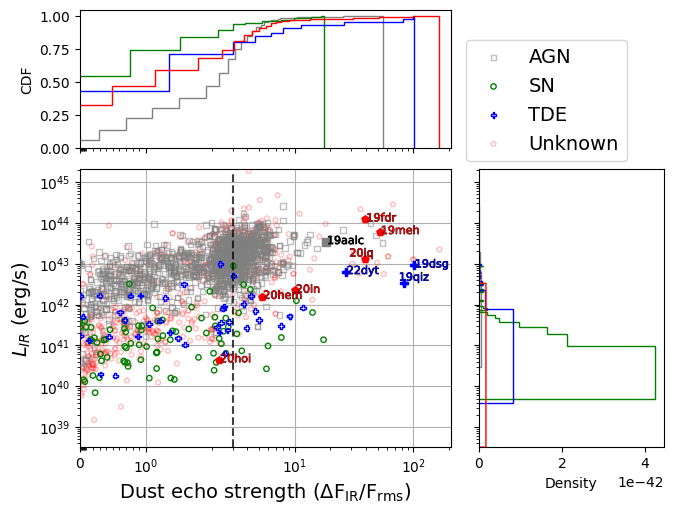

In [74]:
mapping = {'ZTF19aapreis':'19dsg',
           'ZTF19aatubsj':'19fdr','ZTF19aaejtoy':'19aalc',
           'ZTF19abzrhgq':'19qiz','ZTF22aacgcwv':'22dyt',
             'ZTF19abclykm':'19meh', 'ZTF20aabcemq':'20iq',
             'ZTF20aaaweke':'20in', 'ZTF20aaurfwa':'20hem','ZTF18aakkrjm':'20hoi'}

mappingKeys = list(mapping.keys())
mappingKeys.sort()
mapping = {i: mapping[i] for i in mappingKeys}
    
scatter_histogram_plot(dust_echoes_for_lum,redshift_df['lum_IR'].values,logy=True,logx=True,save=False,xlabel=param_label_dict['df_over_rms'],
                       ylabel=r'$L_{IR}$ (erg/s)',different_class_info=redshift_df,mark_certain_flares=True,
                       filtlist=[],savename='dfoverrms_vs_lumir.pdf',fsize=14)

In [157]:
scatter_histogram_plot('MBH','opt_df_over_rms',logy=True,save=saveit,filtlist=[],mark_certain_flares=True)

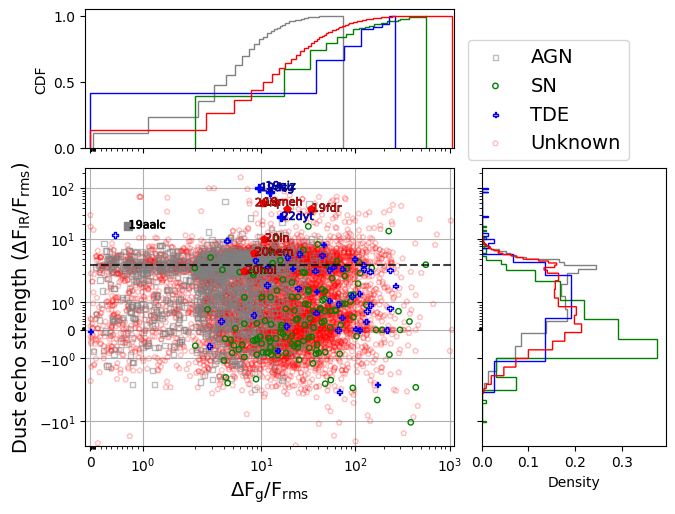

In [31]:

scatter_histogram_plot('opt_df_over_rms',df_over_rms['df_over_rms'],logy=True,logx=True,save=False,xlabel=param_label_dict['opt_df_over_rms'],
                       ylabel=r'Dust echo strength ($\Delta$F$_{\text{IR}}/\text{F}_{\text{rms}}$)',different_class_info=class_info_for_rms,mark_certain_flares=True,
                       filtlist=[],savename='optrms_vs_dfoverms.png',fsize=14)

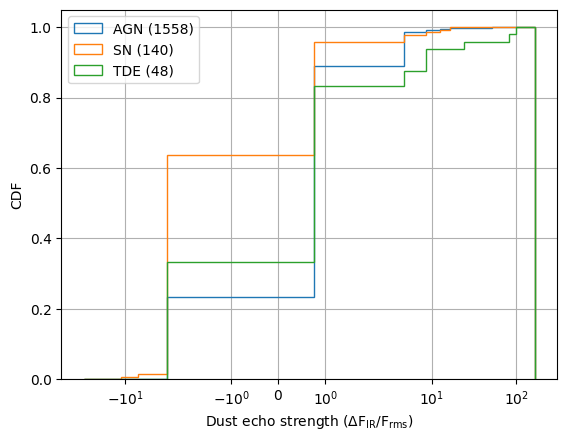

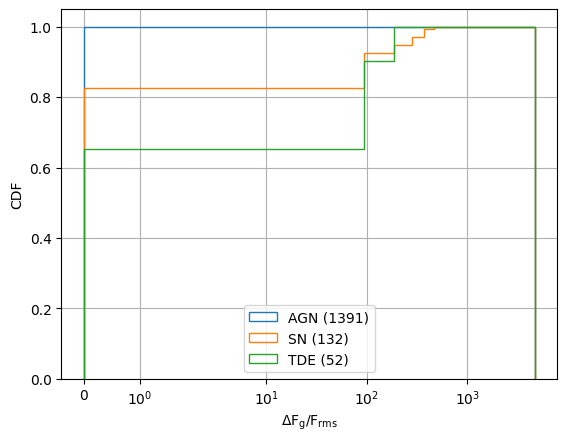

In [32]:
def dust_echo_CDF(density=True,n_bins=50):
    ztfmask = np.isin(class_info['ztf_id'].values,df_over_rms['name'])
    classes = class_info['classification'][ztfmask]


    dfrms_data = np.array(df_over_rms['df_over_rms'])
    n_bins = np.histogram_bin_edges(dfrms_data,bins=n_bins)

    fig,ax = plt.subplots()
    ax.set(xscale='symlog')
    for i,c in enumerate(np.unique(classes)):
        if c == 'Unknown':
            continue
        classmask = classes == c
        n, bins, patches = ax.hist(dfrms_data[classmask], n_bins, density=density, histtype='step',
                           cumulative=True, label=f'{c} ({classmask.sum()})')

    ax.set_xlabel(r'Dust echo strength ($\Delta$F$_{\text{IR}}/\text{F}_{\text{rms}}$)')
    if density: ylabel = "CDF"
    else: ylabel = 'Cumulative sum'
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()
    plt.show()

dust_echo_CDF()

def opt_df_over_rms_CDF(density=True,n_bins=50):
    classes = masked_class_info['classification']
    dfrms_data = catalogue_masked_full['opt_df_over_rms'].values

    quality_mask = catalogue_masked_full['fit_quality_good'].values

    classes = classes[quality_mask]
    dfrms_data = dfrms_data[quality_mask]

    n_bins = np.histogram_bin_edges(dfrms_data,bins=n_bins)

    fig,ax = plt.subplots()
    ax.set(xscale='symlog')
    for i,c in enumerate(np.unique(classes)):
        if c == 'Unknown':
            continue
        classmask = classes == c
        n, bins, patches = ax.hist(dfrms_data[classmask], n_bins, density=density, histtype='step',
                           cumulative=True, label=f'{c} ({classmask.sum()})')

    ax.set_xlabel(r'$\Delta$F$_{\text{g}}/\text{F}_{\text{rms}}$')
    if density: ylabel = "CDF"
    else: ylabel = 'Cumulative sum'
    ax.set_ylabel(ylabel)
    ax.grid(True)
    ax.legend()
    plt.show()

opt_df_over_rms_CDF()

KS test on extreme AGN vs other AGN

In [33]:
fullcatalogue_masked = fullcatalogue[fullcatalogue['classified'].values]
class_info_masked = class_info[class_info['fit_exists']] #class info for which there is known fit

nonzero_mbh_indx = np.nonzero(class_info_masked['MBH'].values)
print(sum((class_info_masked['classification'] == 'AGN').values * fullcatalogue_masked['fit_quality_good'].values))

fullcatalogue_masked = fullcatalogue_masked.iloc[nonzero_mbh_indx]
class_info_masked = class_info_masked.iloc[nonzero_mbh_indx]

fitqualitymask = fullcatalogue_masked['fit_quality_good'].values
# selectionmask = fullcatalogue_masked['selection_old'].values
selectionmask = fullcatalogue_masked['in_selection'].values
AGNmask = np.array(class_info_masked['classification'] == 'AGN')


print(sum((class_info_masked['classification'] == 'AGN').values * fullcatalogue_masked['fit_quality_good'].values))
strong_AGN_mask =  fitqualitymask  * AGNmask * selectionmask 
print(np.sum(strong_AGN_mask))
other_AGN_mask =   fitqualitymask  * AGNmask * np.invert(selectionmask) 


strong_mbh = class_info_masked['MBH'][strong_AGN_mask].values
other_mbh = class_info_masked['MBH'][other_AGN_mask].values
other_ztfs = class_info_masked['ztf_id'][other_AGN_mask].values
other_mask_dust_echo = np.isin(other_ztfs,np.array(df_over_rms['name'][np.array(df_over_rms['df_over_rms'] > 0)])) 
other_mbh  = other_mbh[other_mask_dust_echo]

strong_redshifts = class_info_masked['redshift'][strong_AGN_mask].values
other_redshifts = class_info_masked['redshift'][other_AGN_mask].values[other_mask_dust_echo]


print(f'There are {len(strong_mbh)} strong AGN bursts with known MBH and {len(other_mbh)} others')
print(f'Ratio other/strong: {len(other_mbh)/len(strong_mbh)}')


1391
1389
84
There are 84 strong AGN bursts with known MBH and 1127 others
Ratio other/strong: 13.416666666666666


KstestResult(statistic=0.1831558710440698, pvalue=0.009071146857215393, statistic_location=7.47806605362, statistic_sign=-1)


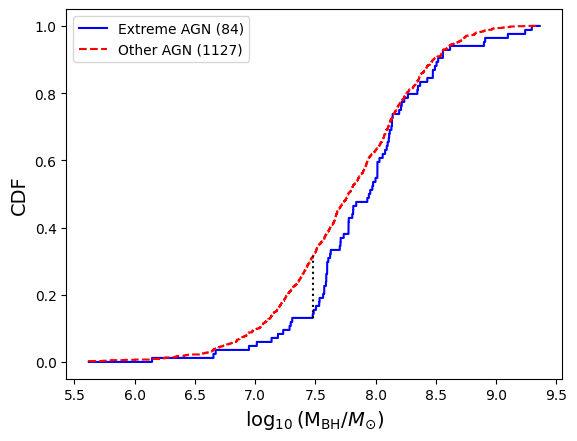

0.346119 0.0145263 0.35


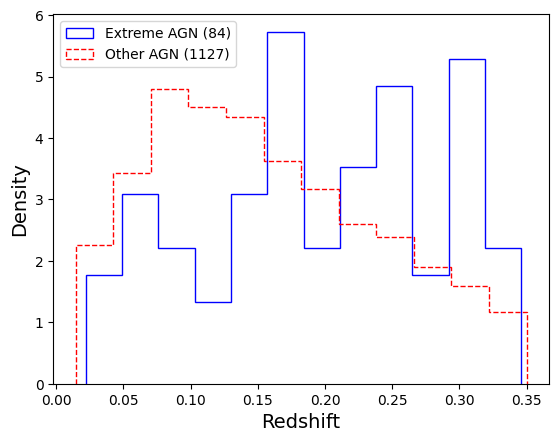

In [34]:
data1 = np.sort(strong_mbh)
data2 = np.sort(other_mbh)
n1 = data1.shape[0]
n2 = data2.shape[0]

data_all = np.concatenate([data1, data2])
# using searchsorted solves equal data problem
cdf1 = np.searchsorted(data1, data_all, side='right') / n1
cdf2 = np.searchsorted(data2, data_all, side='right') / n2


fig,ax = plt.subplots()
ax.set_xlabel(param_label_dict['MBH'],fontsize=14)
ax.set_ylabel('CDF',fontsize=14)
ax.step(np.sort(data_all),np.sort(cdf1),label=f'Extreme AGN ({strong_mbh.shape[0]})',color='blue')
ax.step(np.sort(data_all),np.sort(cdf2),label=f'Other AGN ({other_mbh.shape[0]})',color='red',linestyle='dashed')
# binsstrong = ax.hist(strong_mbh,density=True,cumulative=True,histtype='step',bins='auto',label=f'Extreme ({strong_mbh.shape[0]})')
# ax.hist(other_mbh,density=True,cumulative=True,histtype='step',bins='auto',label=f'Other ({other_mbh.shape[0]})')
# print(binsstrong[1])

ks = ks_2samp(strong_mbh,other_mbh)
print(ks)
# print(np.argmax(np.abs(strong_cdf - other_cdf)))
# ax.set_title(f'p-value: {(ks.pvalue * 1e10):.3f} ' + r'$\cdot10^{-10}$')
closest = lambda x,y: np.argmin(np.abs(x-y))
ax.vlines(ks.statistic_location,cdf1[closest(data_all,ks.statistic_location)],cdf2[closest(data_all,ks.statistic_location)],colors='black',linestyles='dotted')

ax.legend()

# plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_CDFS.png'),dpi=400,bbox_inches='tight')
plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_CDFS.pdf'),bbox_inches='tight')
plt.show()

# is_sorted = lambda x: [x[i] > x[i-1] for i in range(1,x.shape[0])]
# sum(is_sorted(data_all))

# print(ks.statistic, 1.48*np.sqrt((n1+n2)/(n1*n2)))


print(max(strong_redshifts),min(other_redshifts),max(other_redshifts))

plt.figure()
plt.hist(strong_redshifts,density=True,histtype='step',label=f'Extreme AGN ({strong_mbh.shape[0]})',color='blue',bins=12)
plt.hist(other_redshifts,density=True,histtype='step',label=f'Other AGN ({other_mbh.shape[0]})',color='red',linestyle='dashed',bins=12)
plt.legend()
plt.xlabel('Redshift',fontsize=14)
plt.ylabel('Density',fontsize=14)
# plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_redshifts.png'),dpi=400,bbox_inches='tight')
plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_redshifts.pdf'),bbox_inches='tight')
plt.show()

25
KstestResult(statistic=0.9004761904761904, pvalue=1.6367546319049355e-17, statistic_location=7.060512329587361, statistic_sign=-1)


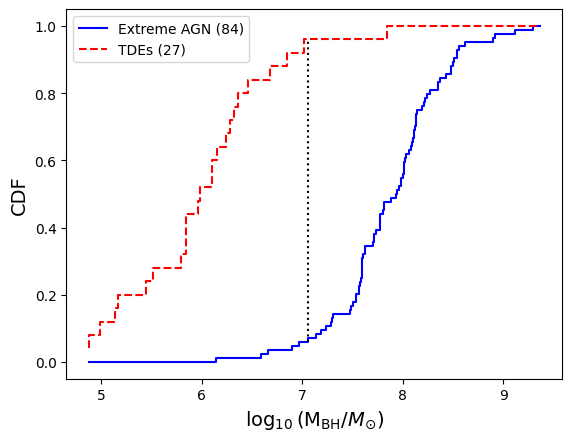

0.346119 0.0145263 0.35


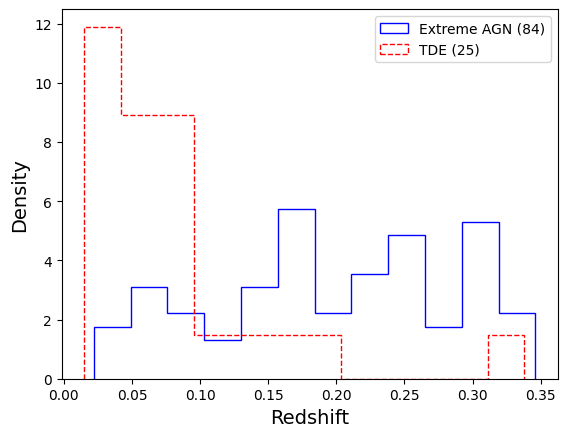

In [111]:
data1 = np.sort(strong_mbh)
tdeclassinfo = class_info[class_info['fit_exists'].values]
tde_mask =   np.array(fullcatalogue[fullcatalogue['classified'].values]['fit_quality_good'] * (masked_class_info['classification'].values == 'TDE')) * (masked_class_info['MBH'].values != 0)
tde_redshifts = np.array(neowise[(neowise['classification'] == 'TDE') * (neowise['MBH'] != 0)]['redshift'])
print(sum(tde_mask))
# strong_mbh = class_info_masked['MBH'][strong_AGN_mask].values
tde_mbh = masked_class_info['MBH'][tde_mask].values
data2 = np.sort(tde_mbh)
n1 = data1.shape[0]
n2 = data2.shape[0]

data_all = np.concatenate([data1, data2])
# using searchsorted solves equal data problem
cdf1 = np.searchsorted(data1, data_all, side='right') / n1
cdf2 = np.searchsorted(data2, data_all, side='right') / n2


fig,ax = plt.subplots()
ax.set_xlabel(param_label_dict['MBH'],fontsize=14)
ax.set_ylabel('CDF',fontsize=14)
ax.step(np.sort(data_all),np.sort(cdf1),label=f'Extreme AGN ({strong_mbh.shape[0]})',color='blue')
ax.step(np.sort(data_all),np.sort(cdf2),label=f'TDEs ({tde_mbhs.shape[0]})',color='red',linestyle='dashed')
# binsstrong = ax.hist(strong_mbh,density=True,cumulative=True,histtype='step',bins='auto',label=f'Extreme ({strong_mbh.shape[0]})')
# ax.hist(other_mbh,density=True,cumulative=True,histtype='step',bins='auto',label=f'Other ({other_mbh.shape[0]})')
# print(binsstrong[1])

ks = ks_2samp(strong_mbh,tde_mbh)
print(ks)
# print(np.argmax(np.abs(strong_cdf - other_cdf)))
# ax.set_title(f'p-value: {(ks.pvalue * 1e10):.3f} ' + r'$\cdot10^{-10}$')
closest = lambda x,y: np.argmin(np.abs(x-y))
ax.vlines(ks.statistic_location,cdf1[closest(data_all,ks.statistic_location)],cdf2[closest(data_all,ks.statistic_location)],colors='black',linestyles='dotted')

ax.legend()

# plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_CDFS.png'),dpi=400,bbox_inches='tight')
plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_TDE_CDFS.pdf'),bbox_inches='tight')
plt.show()

# is_sorted = lambda x: [x[i] > x[i-1] for i in range(1,x.shape[0])]
# sum(is_sorted(data_all))

# print(ks.statistic, 1.48*np.sqrt((n1+n2)/(n1*n2)))


print(max(strong_redshifts),min(other_redshifts),max(other_redshifts))

plt.figure()
plt.hist(strong_redshifts,density=True,histtype='step',label=f'Extreme AGN ({strong_mbh.shape[0]})',color='blue',bins=12)
plt.hist(tde_redshifts,density=True,histtype='step',label=f'TDE ({tde_redshifts.shape[0]})',color='red',linestyle='dashed',bins=12)
plt.legend()
plt.xlabel('Redshift',fontsize=14)
plt.ylabel('Density',fontsize=14)
# plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_redshifts.png'),dpi=400,bbox_inches='tight')
plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_TDE_redshifts.pdf'),bbox_inches='tight')
plt.show()

In [125]:
masked_class_info[(masked_class_info['classification'].values == 'Unknown') * (masked_class_info['MBH'].values != 0) * (fullcatalogue[fullcatalogue['classified'].values]['in_selection'].values)].shape

(43, 8)

KstestResult(statistic=0.2686822342935053, pvalue=0.005144773684402156, statistic_location=7.1, statistic_sign=1)


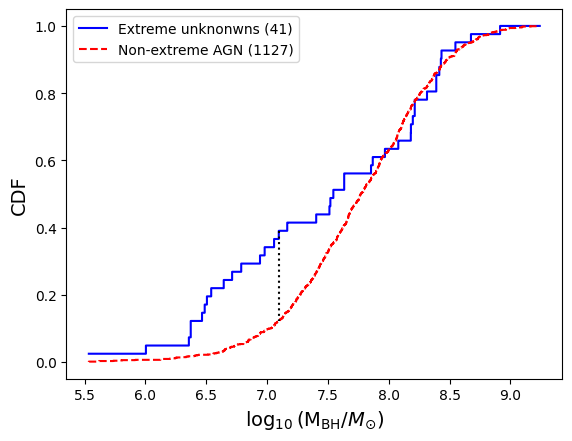

0.346119 0.0145263 0.35


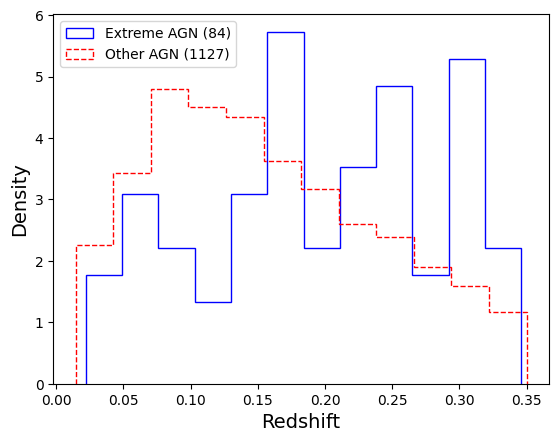

In [127]:
extreme_unknowns_mask = np.array(fullcatalogue[fullcatalogue['classified'].values]['fit_quality_good'] * (fullcatalogue[fullcatalogue['classified'].values]['in_selection']) * \
                                (masked_class_info['classification'].values == 'Unknown') * (masked_class_info['MBH'].values != 0))

extreme_unknowns_mbh = masked_class_info['MBH'].values[extreme_unknowns_mask]

data1 = np.sort(extreme_unknowns_mbh)
data2 = np.sort(other_mbh)
n1 = data1.shape[0]
n2 = data2.shape[0]

data_all = np.concatenate([data1, data2])
# using searchsorted solves equal data problem
cdf1 = np.searchsorted(data1, data_all, side='right') / n1
cdf2 = np.searchsorted(data2, data_all, side='right') / n2


fig,ax = plt.subplots()
ax.set_xlabel(param_label_dict['MBH'],fontsize=14)
ax.set_ylabel('CDF',fontsize=14)
ax.step(np.sort(data_all),np.sort(cdf1),label=f'Extreme unknonwns ({extreme_unknowns_mbh.shape[0]})',color='blue')
ax.step(np.sort(data_all),np.sort(cdf2),label=f'Non-extreme AGN ({other_mbh.shape[0]})',color='red',linestyle='dashed')
# binsstrong = ax.hist(strong_mbh,density=True,cumulative=True,histtype='step',bins='auto',label=f'Extreme ({strong_mbh.shape[0]})')
# ax.hist(other_mbh,density=True,cumulative=True,histtype='step',bins='auto',label=f'Other ({other_mbh.shape[0]})')
# print(binsstrong[1])

ks = ks_2samp(extreme_unknowns_mbh,other_mbh)
print(ks)
# print(np.argmax(np.abs(strong_cdf - other_cdf)))
# ax.set_title(f'p-value: {(ks.pvalue * 1e10):.3f} ' + r'$\cdot10^{-10}$')
closest = lambda x,y: np.argmin(np.abs(x-y))
ax.vlines(ks.statistic_location,cdf1[closest(data_all,ks.statistic_location)],cdf2[closest(data_all,ks.statistic_location)],colors='black',linestyles='dotted')

ax.legend()

# plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_CDFS.pdf'),bbox_inches='tight')
plt.show()

# is_sorted = lambda x: [x[i] > x[i-1] for i in range(1,x.shape[0])]
# sum(is_sorted(data_all))

# print(ks.statistic, 1.48*np.sqrt((n1+n2)/(n1*n2)))


print(max(strong_redshifts),min(other_redshifts),max(other_redshifts))

plt.figure()
plt.hist(strong_redshifts,density=True,histtype='step',label=f'Extreme AGN ({strong_mbh.shape[0]})',color='blue',bins=12)
plt.hist(other_redshifts,density=True,histtype='step',label=f'Other AGN ({other_mbh.shape[0]})',color='red',linestyle='dashed',bins=12)
plt.legend()
plt.xlabel('Redshift',fontsize=14)
plt.ylabel('Density',fontsize=14)
# plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_redshifts.png'),dpi=400,bbox_inches='tight')
plt.savefig(os.path.join(r'C:\Users\timvd\Documents\Uni 2023-2024\First Research Project\Plots','AGN_redshifts.pdf'),bbox_inches='tight')
plt.show()

In [35]:
tde_info = masked_class_info[(masked_class_info['classification'] == 'TDE').values *( masked_class_info['MBH'].values !=0)][['ztf_id','MBH']]
tde_info[tde_info['MBH'].values > 8]

,ztf_id,MBH
9478,ZTF20abowque,8.267107


KstestResult(statistic=0.5465608465608466, pvalue=6.298182618222896e-06, statistic_location=6.363003178704943, statistic_sign=1)


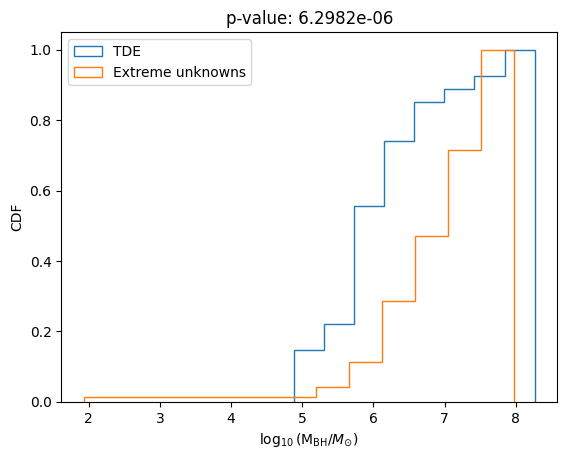

In [36]:
unknown_mbhs = unknown_with_mbh_extreme['MBH'][:100].values
unknown_mbhs = unknown_mbhs[unknown_mbhs <= 8]
tde_mask = (masked_class_info['classification'] == 'TDE').values * (masked_class_info['MBH'] != 0)
tde_mbhs = masked_class_info['MBH'][tde_mask].values

fig,ax = plt.subplots()
ax.set(xlabel=param_label_dict['MBH'],ylabel='CDF')
ax.hist(tde_mbhs,density=True,cumulative=True,histtype='step',bins='auto',label=f'TDE')
ax.hist(unknown_mbhs,density=True,cumulative=True,histtype='step',bins='auto',label='Extreme unknowns')

ks = ks_2samp(tde_mbhs,unknown_mbhs)
print(ks)
# print(np.argmax(np.abs(strong_cdf - other_cdf)))
ax.set_title(f'p-value: {ks.pvalue:.4e}')
# ax.vlines(ks.statistic_location,0,1)
ax.legend()
plt.show()
